In [1]:
# %tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19
print(tf.__version__)


2.3.0


In [2]:
trian_dir = 'PKN/rps/'
test_dir = 'PKN/rps-test-set/'
valid_dir = 'PKN/valid_rps/'

### Sprawdzenie, czy moja karta graficzna będzie używana podczas trenowania modelu. 

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Tworzenie ścieżek do zbiorów, oraz przedstawienie ilość obiektów w danej klasie i zbiorze. 

In [5]:
train_rock_dir = os.path.join(trian_dir,'rock')
train_paper_dir = os.path.join(trian_dir,'paper')
train_scissors_dir = os.path.join(trian_dir,'scissors')


print('Kamień - Zbiór treningowy:', len(os.listdir(train_rock_dir)))
print('Papier - Zbiór treningowy:', len(os.listdir(train_paper_dir)))
print('Nożyczki - Zbiór treningowy:', len(os.listdir(train_scissors_dir)))

valid_rock_dir = os.path.join(valid_dir,'rock')
valid_paper_dir  = os.path.join(valid_dir,'paper')
valid_scissors_dir= os.path.join(valid_dir,'scissors')

print('Kamień - Zbiór walidacyjny:', len(os.listdir(valid_rock_dir)))
print('Papier - Zbiór walidacyjny:', len(os.listdir(valid_paper_dir)))
print('Nożyczki - Zbiór walidacyjny:', len(os.listdir(valid_scissors_dir)))


rock_test_dir = os.path.join(test_dir,'rock')
paper_test_dir = os.path.join(test_dir,'paper')
scissors_test_dir = os.path.join(test_dir,'scissors')



print('Kamień - Zbiór testowy:', len(os.listdir(rock_test_dir)))
print('Papier - Zbiór testowy:', len(os.listdir(paper_test_dir)))
print('Nożyczki - Zbiór testowy:', len(os.listdir(scissors_test_dir)))








Kamień - Zbiór treningowy: 763
Papier - Zbiór treningowy: 763
Nożyczki - Zbiór treningowy: 763
Kamień - Zbiór walidacyjny: 77
Papier - Zbiór walidacyjny: 77
Nożyczki - Zbiór walidacyjny: 77
Kamień - Zbiór testowy: 124
Papier - Zbiór testowy: 124
Nożyczki - Zbiór testowy: 124


### Tworzę klasy zbioru testowego i trenującego.

In [6]:

train_rock_fnames = os.listdir(os.path.join(trian_dir,'rock'))
train_paper_fnames = os.listdir(os.path.join(trian_dir,'paper'))
train_scissors_fnames = os.listdir(os.path.join(trian_dir,'scissors'))


valid_rock_fnames = os.listdir(os.path.join(valid_dir,'rock'))
valid_paper_fnames = os.listdir(os.path.join(valid_dir,'paper'))
valid_scissors_fnames = os.listdir(os.path.join(valid_dir,'scissors'))



test_rock_fnames = os.listdir(os.path.join(test_dir,'rock'))
test_paper_fnames = os.listdir(os.path.join(test_dir,'paper'))
test_scissors_fnames = os.listdir(os.path.join(test_dir,'scissors'))

print('Liczba elementów zbioru walidacyjnego: {}'.format(int(len(valid_rock_fnames))))
print('Liczba elementów zbioru trenującego: {}'.format(int(len(train_rock_fnames))))
print('Liczba elementów zbioru testowego: {}'.format(len(test_scissors_fnames)))

Liczba elementów zbioru walidacyjnego: 77
Liczba elementów zbioru trenującego: 763
Liczba elementów zbioru testowego: 124


### Prezentacja zdjęć kążdego z obieków.

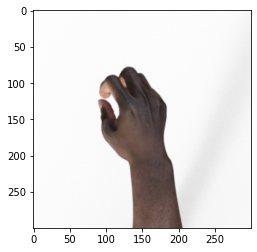

In [7]:

from PIL import Image
img_path = os.path.join(train_rock_dir, train_rock_fnames[520])
img_path
image = Image.open(img_path)
plt.imshow(image)

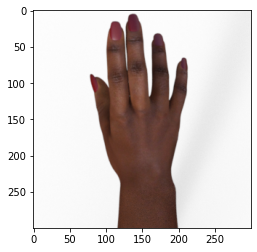

In [8]:

img_path = os.path.join(train_paper_dir, train_paper_fnames[520])
image = Image.open(img_path)
plt.imshow(image)

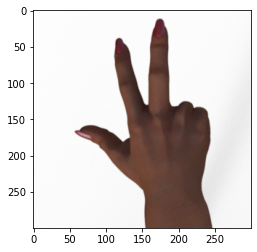

In [9]:

img_path = os.path.join(train_scissors_dir, train_scissors_fnames[520])
image = Image.open(img_path)
plt.imshow(image)

### Augmentacja danych

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=40,      # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=trian_dir,
                                                   target_size=(300, 300),
                                                   batch_size=32,
                                                   class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(300, 300),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 2289 images belonging to 3 classes.
Found 231 images belonging to 3 classes.


In [11]:
import PIL.Image
from tensorflow.keras.preprocessing.image import array_to_img as ati

### Prezentacja zdjęć jakie będą generwoane podczas uczenia modelu 

In [13]:
def display_augmented_images(directory, picture_name):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    img_path = os.path.join(directory, picture_name)

    img = PIL.Image.open(img_path)

    x = np.asarray(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(ati(batch[0]))
        i += 1
        if i % 13 == 0:
            break

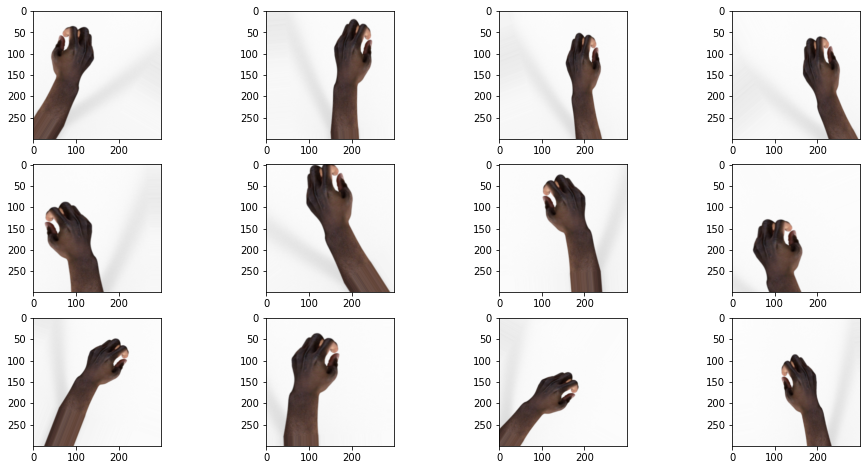

In [15]:
display_augmented_images(train_rock_dir, train_rock_fnames[520])

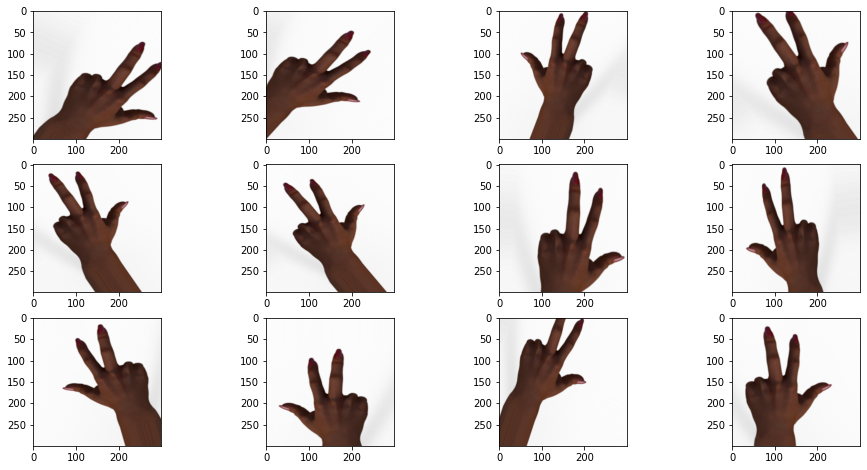

In [16]:
display_augmented_images(train_scissors_dir, train_scissors_fnames[520])

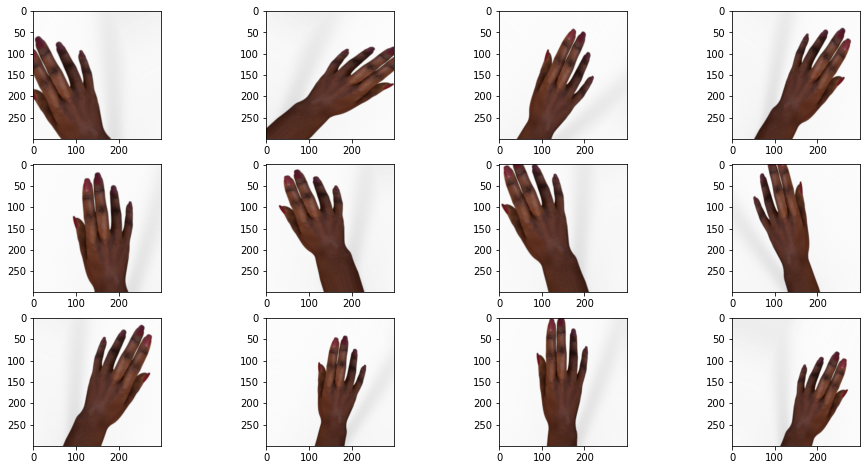

In [17]:
display_augmented_images(train_paper_dir, train_paper_fnames[520])

## Budowa modelu

In [18]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       1

In [19]:
steps_per_epoch = 2520/32
steps_per_epoch
validation_steps = 77/32

In [ ]:
Tworzenie chechpoint'ów podczas nauki moedlu, aby wykorzystać najlepszy. 

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint


filepath ='model/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#### EarlyStopping służy do zatrzymania nauki modelu, jeśli nasz model nie robi postępów w nauce. Nie zostanie używy w naucę ponieważ, chce aby model wytenował się do końca. 

from tensorflow.keras.callbacks import EarlyStopping\
domyślnie mode='auto'\
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)

In [22]:

history = model.fit(x = train_generator,
                             epochs=100,    # Liczba cykli trenowania
                             validation_steps = validation_steps,
                            validation_data= valid_generator,
                            callbacks=[checkpoint])

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 1.0946 - accuracy: 0.3565
Epoch 00001: val_accuracy improved from -inf to 0.46875, saving model to model\weights-01-0.4688.hdf5
72/72 [==============================] - 50s 692ms/step - loss: 1.0946 - accuracy: 0.3565 - val_loss: 1.0819 - val_accuracy: 0.4688
Epoch 2/100
72/72 [==============================] - ETA: 0s - loss: 1.0802 - accuracy: 0.4181
Epoch 00002: val_accuracy did not improve from 0.46875
72/72 [==============================] - 38s 522ms/step - loss: 1.0802 - accuracy: 0.4181 - val_loss: 1.0704 - val_accuracy: 0.3958
Epoch 3/100
72/72 [==============================] - ETA: 0s - loss: 1.0639 - accuracy: 0.4408
Epoch 00003: val_accuracy improved from 0.46875 to 0.55208, saving model to model\weights-03-0.5521.hdf5
72/72 [==============================] - 37s 520ms/step - loss: 1.0639 - accuracy: 0.4408 - val_loss: 1.0310 - val_accuracy: 0.5521
Epoch 4/100
72/72 [==============================] - ETA:

Epoch 28/100
72/72 [==============================] - ETA: 0s - loss: 0.4572 - accuracy: 0.8397
Epoch 00028: val_accuracy did not improve from 0.90625
72/72 [==============================] - 35s 492ms/step - loss: 0.4572 - accuracy: 0.8397 - val_loss: 0.6336 - val_accuracy: 0.7500
Epoch 29/100
72/72 [==============================] - ETA: 0s - loss: 0.4619 - accuracy: 0.8287
Epoch 00029: val_accuracy did not improve from 0.90625
72/72 [==============================] - 35s 492ms/step - loss: 0.4619 - accuracy: 0.8287 - val_loss: 0.3401 - val_accuracy: 0.9062
Epoch 30/100
72/72 [==============================] - ETA: 0s - loss: 0.4367 - accuracy: 0.8423
Epoch 00030: val_accuracy did not improve from 0.90625
72/72 [==============================] - 35s 490ms/step - loss: 0.4367 - accuracy: 0.8423 - val_loss: 0.5052 - val_accuracy: 0.8333
Epoch 31/100
72/72 [==============================] - ETA: 0s - loss: 0.4386 - accuracy: 0.8497
Epoch 00031: val_accuracy did not improve from 0.90625


72/72 [==============================] - ETA: 0s - loss: 0.2593 - accuracy: 0.9056
Epoch 00056: val_accuracy did not improve from 0.95833
72/72 [==============================] - 38s 522ms/step - loss: 0.2593 - accuracy: 0.9056 - val_loss: 0.2894 - val_accuracy: 0.8958
Epoch 57/100
72/72 [==============================] - ETA: 0s - loss: 0.2693 - accuracy: 0.9069
Epoch 00057: val_accuracy did not improve from 0.95833
72/72 [==============================] - 38s 531ms/step - loss: 0.2693 - accuracy: 0.9069 - val_loss: 0.5583 - val_accuracy: 0.8125
Epoch 58/100
72/72 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.9069
Epoch 00058: val_accuracy did not improve from 0.95833
72/72 [==============================] - 38s 531ms/step - loss: 0.2607 - accuracy: 0.9069 - val_loss: 0.5737 - val_accuracy: 0.8021
Epoch 59/100
72/72 [==============================] - ETA: 0s - loss: 0.2376 - accuracy: 0.9279
Epoch 00059: val_accuracy did not improve from 0.95833
72/72 [======

Epoch 85/100
72/72 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.9423
Epoch 00085: val_accuracy did not improve from 0.95833
72/72 [==============================] - 38s 521ms/step - loss: 0.1704 - accuracy: 0.9423 - val_loss: 0.2708 - val_accuracy: 0.8958
Epoch 86/100
72/72 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9380
Epoch 00086: val_accuracy did not improve from 0.95833
72/72 [==============================] - 38s 522ms/step - loss: 0.1816 - accuracy: 0.9380 - val_loss: 0.3227 - val_accuracy: 0.9062
Epoch 87/100
72/72 [==============================] - ETA: 0s - loss: 0.1748 - accuracy: 0.9401
Epoch 00087: val_accuracy did not improve from 0.95833
72/72 [==============================] - 38s 532ms/step - loss: 0.1748 - accuracy: 0.9401 - val_loss: 0.3103 - val_accuracy: 0.9375
Epoch 88/100
72/72 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9484
Epoch 00088: val_accuracy did not improve from 0.95833


In [41]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

Wykorzystamy 97 epoke jako model końcowy.\
W raz z czasem trenowania modelu błąd zbioru treningowego spada, lecz błąd zbioru validacyjnego podczas nauki ma dużą wariancje.\
Niechowuje się stabilnie jest błąd zbioru treningowego.

In [42]:
model = tf.keras.models.load_model('model/weights-97-0.9792.hdf5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       1

### Sprawdzenie modelu na zbiorze niewidzianym przez nas model. 

In [43]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(300, 300),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

y_prob = model.predict(test_generator, test_generator.samples)
y_prob

Found 372 images belonging to 3 classes.


array([[9.0435892e-01, 2.6366049e-03, 9.3004525e-02],
       [9.0945852e-01, 2.4438766e-03, 8.8097528e-02],
       [9.2135417e-01, 2.2179582e-03, 7.6427862e-02],
       ...,
       [1.3588854e-03, 1.5700627e-05, 9.9862540e-01],
       [1.7402554e-03, 1.4279383e-05, 9.9824548e-01],
       [1.9379726e-03, 1.4293965e-05, 9.9804771e-01]], dtype=float32)

### Predykcja modelu dla obiektów testowych

In [71]:
predictions_df = pd.DataFrame(y_prob)
predictions_df.head()

,0,1,2
0,0.904359,0.002637,0.093005
1,0.909459,0.002444,0.088098
2,0.921354,0.002218,0.076428
3,0.932065,0.001901,0.066034
4,0.950621,0.001065,0.048314


Weźmy pod lupę pierwsze zdjęcie (pozycja 0) model uważa, że na 90.4% jest to papier, na 0.2% jest to kamień, oraz na 9.3% są to nożyczki.\
Predykcja z nawiększą pewnościa uważamy za przewidywanie modelu. 

In [45]:
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [46]:
predictions  = pd.DataFrame({'class': y_pred})
predictions

,class
0,0
1,0
2,0
3,0
4,0
...,...
367,2
368,2
369,2
370,2


#### Metki będące w 100% dobrze zakwalifikowane.

In [75]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

#### Metki zakwalafikowane przez nas model. 

In [76]:
y_pred = predictions['class'].values
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [77]:
test_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [78]:
classes = list(test_generator.class_indices.keys())
classes

['paper', 'rock', 'scissors']

In [79]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[110,   9,   5],
       [  0, 124,   0],
       [  0,   0, 124]], dtype=int64)

## Tablica pomyłek

In [80]:
def plot_confusion_matrix(cm):
    # Mulitclass classification, 3 classes
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=classes, index=classes[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

import plotly.figure_factory as ff
plot_confusion_matrix(cm)

Patrząc na Tablice pomyłek, widzimy że model ma problem z rozróżnieniem papieru. W 9 przypadkach zakwalifikował go jako kamień, oraz 5 razy jako nożyczki. 

In [57]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


              precision    recall  f1-score   support

       paper       1.00      0.89      0.94       124
        rock       0.93      1.00      0.96       124
    scissors       0.96      1.00      0.98       124

    accuracy                           0.96       372
   macro avg       0.96      0.96      0.96       372
weighted avg       0.96      0.96      0.96       372



Precyzja modelu wynosi 96%

## Przyjrzyjmy się danym które zostały nieprawidłowo zakfalifikowane. 

In [58]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors

,y_true,y_pred
paper\testpaper01-00.png,0,0
paper\testpaper01-01.png,0,0
paper\testpaper01-02.png,0,0
paper\testpaper01-03.png,0,0
paper\testpaper01-04.png,0,0
...,...,...
scissors\testscissors04-26.png,2,2
scissors\testscissors04-27.png,2,2
scissors\testscissors04-28.png,2,2
scissors\testscissors04-29.png,2,2


In [63]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_incorrect
paper\testpaper01-00.png,0,0,0
paper\testpaper01-01.png,0,0,0
paper\testpaper01-02.png,0,0,0
paper\testpaper01-03.png,0,0,0
paper\testpaper01-04.png,0,0,0
...,...,...,...
scissors\testscissors04-26.png,2,2,0
scissors\testscissors04-27.png,2,2,0
scissors\testscissors04-28.png,2,2,0
scissors\testscissors04-29.png,2,2,0


In [64]:
errors[errors['is_incorrect'] == 1].index


Index(['paper\testpaper03-00.png', 'paper\testpaper03-01.png',
       'paper\testpaper03-02.png', 'paper\testpaper03-03.png',
       'paper\testpaper03-04.png', 'paper\testpaper03-05.png',
       'paper\testpaper03-06.png', 'paper\testpaper03-07.png',
       'paper\testpaper03-08.png', 'paper\testpaper03-09.png',
       'paper\testpaper03-10.png', 'paper\testpaper03-11.png',
       'paper\testpaper03-12.png', 'paper\testpaper03-13.png'],
      dtype='object')

(-0.5, 299.5, 299.5, -0.5)

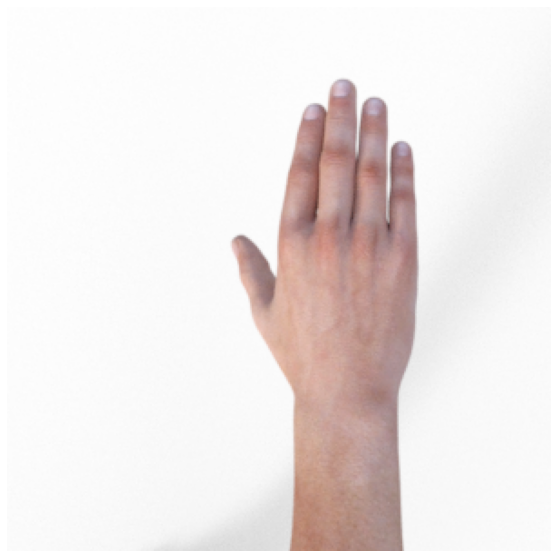

In [65]:

img_path = os.path.join(test_dir, 'paper/testpaper03-00.png')

img = Image.open(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 299.5, 299.5, -0.5)

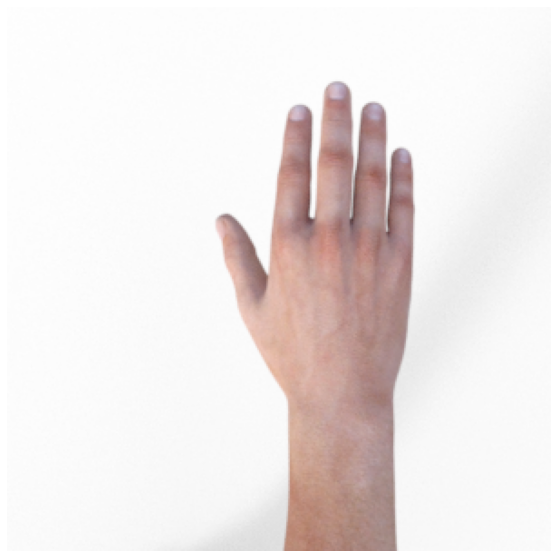

In [66]:

img_path = os.path.join(test_dir, 'paper/testpaper03-14.png')

img = Image.open(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

Oba przykłady na pewno przedstawiają papier, wiec nie są to zdjęcia nieprawidłowo ometkowane. Model nie jest doskonały, ale dobrze sobie radzi. 